# MNIST data set loader

In [1]:
import gzip
import numpy as np
import os

def load_mnist(base='./'):

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()
print X_train.shape, y_train[0]
#y_train = np.array([ np.eye(10)[y_train[i]] for i in xrange(len(y_train))], dtype='int32').reshape((-1, 10))
print y_train.shape, y_train[0]

(50000, 1, 28, 28) 5
(50000,) 5


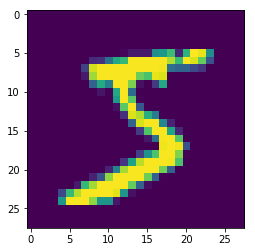

In [83]:
plt.imshow(X_train[0,0])

In [304]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_Y = T.vector("Y", dtype='int32')

In [305]:
net = lasagne.layers.InputLayer((None, 1, 28, 28), input_X, name="input")
layer1 = lasagne.layers.DenseLayer(net, num_units=128, nonlinearity=tanh, name="hidden_dense_layer")
layer2 = lasagne.layers.DenseLayer(layer1, num_units=16, nonlinearity=sigmoid, name="hidden_dense_layer")
#net = lasagne.layers.DropoutLayer(net, p=0.2)
net = lasagne.layers.DenseLayer(layer2, num_units = 10, nonlinearity=softmax, name="output")

In [306]:
Y_predicted = lasagne.layers.get_output(net)

In [307]:
#все веса нейронки (shared-переменные)
weights = lasagne.layers.get_all_params(net)
print weights

[hidden_dense_layer.W, hidden_dense_layer.b, hidden_dense_layer.W, hidden_dense_layer.b, output.W, output.b]


In [308]:
from lasagne.regularization import regularize_layer_params_weighted, l2, l1
from lasagne.regularization import regularize_layer_params
layers = {layer1: 0.1, layer2: 0.5}
l2_penalty = regularize_layer_params_weighted(layers, l2)
#l1_penalty = regularize_layer_params(layer2, l1) * 1e-3
loss = loss + l2_penalty + l1_penalty

loss = lasagne.objectives.categorical_crossentropy(Y_predicted, target_Y).mean()
accuracy = lasagne.objectives.categorical_accuracy(Y_predicted, target_Y).mean()

updates_sgd = lasagne.updates.adadelta(loss, weights)

In [309]:
train_fun = theano.function([input_X, target_Y],[loss, accuracy], updates=updates_sgd)
accuracy_fun = theano.function([input_X, target_Y], accuracy)

In [310]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [311]:
import time

num_epochs = 20
batch_size = 50

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 20 took 3.691s
  training loss (in-iteration):		0.439320
  train accuracy:		89.16 %
  validation accuracy:		94.94 %
Epoch 2 of 20 took 3.534s
  training loss (in-iteration):		0.155710
  train accuracy:		95.57 %
  validation accuracy:		96.53 %
Epoch 3 of 20 took 4.896s
  training loss (in-iteration):		0.102648
  train accuracy:		97.17 %
  validation accuracy:		97.09 %
Epoch 4 of 20 took 4.308s
  training loss (in-iteration):		0.075274
  train accuracy:		97.94 %
  validation accuracy:		97.12 %
Epoch 5 of 20 took 4.751s
  training loss (in-iteration):		0.057116
  train accuracy:		98.49 %
  validation accuracy:		97.35 %
Epoch 6 of 20 took 3.993s
  training loss (in-iteration):		0.043592
  train accuracy:		98.90 %
  validation accuracy:		97.47 %
Epoch 7 of 20 took 3.673s
  training loss (in-iteration):		0.033463
  train accuracy:		99.20 %
  validation accuracy:		97.41 %
Epoch 8 of 20 took 4.751s
  training loss (in-iteration):		0.025901
  train accuracy:		99.42 %
  validation acc

KeyboardInterrupt: 

In [312]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		97.25 %
Нужно больше магии!


## Possible improvements:



 * net size
   * more neurons in layers, 
   * more layers, 
   
 * regularization for preventing overfitting
   * http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout
       * `lasagne.layers.DropoutLayer(предыдущий_слой, p=вероятность_занулить)`
   
 * Try optimizations - adam, rmsprop, nesterov_momentum, adadelta, adagrad
   * converges faster and often to a better optimum
   * try different batch size, number of epoches
   
 * Different nonlinearities in hidden layers
   * tanh, relu, leaky relu, etc